In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import tempfile
temp_dir = tempfile.TemporaryDirectory()
from casatasks import simobserve, tclean, exportfits
import os
import shutil
from casatools import table
from astropy.constants import c
from astropy.time import Time
import astropy.units as U
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import AdaptiveKernel, GaussianKernel, CubicSplineKernel, DiracDeltaKernel
from natsort import natsorted
import math
from math import pi
from tqdm import tqdm
import time
from time import strftime, gmtime
import dask
from typing import Optional
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from random import choices
import simulator as sim

from spectral_cube import SpectralCube
import h5py
os.environ['MPLCONFIGDIR'] = temp_dir.name
pd.options.mode.chained_assignment = None  
def get_data_from_hdf(file):
    data = list()
    column_names = list()
    r = h5py.File(file, 'r')
    for key in r.keys():
        if key == 'Snapshot_99':
            group = r[key]
            for key2 in group.keys():
                column_names.append(key2)
                data.append(group[key2])
    values = np.array(data)
    db = pd.DataFrame(values.T, columns=column_names)     
    return db   

def load_fits(inFile):
    hdu_list = fits.open(inFile)
    data = hdu_list[0].data
    header = hdu_list[0].header
    hdu_list.close()
    return data, header

def write_datacube_to_fits(
    datacube,
    filename,
    channels="frequency",
    overwrite=True,
    ):
        """
        Output the DataCube to a FITS-format file.

        Parameters
        ----------
        filename : string
            Name of the file to write. '.fits' will be appended if not already
            present.

        channels : {'frequency', 'velocity'}, optional
            Type of units used along the spectral axis in output file.
            (Default: 'frequency'.)

        overwrite: bool, optional
            Whether to allow overwriting existing files. (Default: True.)
        """

        datacube.drop_pad()
        if channels == "frequency":
            datacube.freq_channels()
        elif channels == "velocity":
            datacube.velocity_channels()
        else:
            raise ValueError(
                "Unknown 'channels' value "
                "(use 'frequency' or 'velocity'."
            )

        filename = filename if filename[-5:] == ".fits" else filename + ".fits"

        wcs_header = datacube.wcs.to_header()
        wcs_header.rename_keyword("WCSAXES", "NAXIS")

        header = fits.Header()
        header.append(("SIMPLE", "T"))
        header.append(("BITPIX", 16))
        header.append(("NAXIS", wcs_header["NAXIS"]))
        header.append(("NAXIS1", datacube.n_px_x))
        header.append(("NAXIS2", datacube.n_px_y))
        header.append(("NAXIS3", datacube.n_channels))
        header.append(("NAXIS4", 1))
        header.append(("EXTEND", "T"))
        header.append(("CDELT1", wcs_header["CDELT1"]))
        header.append(("CRPIX1", wcs_header["CRPIX1"]))
        header.append(("CRVAL1", wcs_header["CRVAL1"]))
        header.append(("CTYPE1", wcs_header["CTYPE1"]))
        header.append(("CUNIT1", wcs_header["CUNIT1"]))
        header.append(("CDELT2", wcs_header["CDELT2"]))
        header.append(("CRPIX2", wcs_header["CRPIX2"]))
        header.append(("CRVAL2", wcs_header["CRVAL2"]))
        header.append(("CTYPE2", wcs_header["CTYPE2"]))
        header.append(("CUNIT2", wcs_header["CUNIT2"]))
        header.append(("CDELT3", wcs_header["CDELT3"]))
        header.append(("CRPIX3", wcs_header["CRPIX3"]))
        header.append(("CRVAL3", wcs_header["CRVAL3"]))
        header.append(("CTYPE3", wcs_header["CTYPE3"]))
        header.append(("CUNIT3", wcs_header["CUNIT3"]))
        header.append(("CDELT4", wcs_header["CDELT4"]))
        header.append(("CRPIX4", wcs_header["CRPIX4"]))
        header.append(("CRVAL4", wcs_header["CRVAL4"]))
        header.append(("CTYPE4", wcs_header["CTYPE4"]))
        header.append(("CUNIT4", "PAR"))
        header.append(("EPOCH", 2000))
        # header.append(('BLANK', -32768)) #only for integer data
        header.append(("BSCALE", 1.0))
        header.append(("BZERO", 0.0))
        datacube_array_units = datacube._array.unit
        header.append(
            ("DATAMAX", np.max(datacube._array.to_value(datacube_array_units)))
        )
        header.append(
            ("DATAMIN", np.min(datacube._array.to_value(datacube_array_units)))
        )
        
        # long names break fits format, don't let the user set this
        header.append(("OBJECT", "MOCK"))
        header.append(("BUNIT", datacube_array_units.to_string("fits")))
        header.append(("MJD-OBS", Time.now().to_value("mjd")))
        header.append(("BTYPE", "Intensity"))
        header.append(("SPECSYS", wcs_header["SPECSYS"]))

        # flip axes to write
        hdu = fits.PrimaryHDU(
            header=header, data=datacube._array.to_value(datacube_array_units).T
        )
        hdu.writeto(filename, overwrite=overwrite)

        if channels == "frequency":
            datacube.velocity_channels()
        return

def plot_moments(FluxCube, vch, path):
    np.seterr(all='ignore')
    fig = plt.figure(figsize=(16, 5))
    sp1 = fig.add_subplot(1,3,1)
    sp2 = fig.add_subplot(1,3,2)
    sp3 = fig.add_subplot(1,3,3)
    rms = np.std(FluxCube[:16, :16])  # noise in a corner patch where there is little signal
    clip = np.where(FluxCube > 5 * rms, 1, 0)
    mom0 = np.sum(FluxCube, axis=-1)
    mask = np.where(mom0 > .02, 1, np.nan)
    mom1 = np.sum(FluxCube * clip * vch, axis=-1) / mom0
    mom2 = np.sqrt(np.sum(FluxCube * clip * np.power(vch - mom1[..., np.newaxis], 2), axis=-1)) / mom0
    im1 = sp1.imshow(mom0.T, cmap='Greys', aspect=1.0, origin='lower')
    plt.colorbar(im1, ax=sp1, label='mom0 [Jy/beam]')
    im2 = sp2.imshow((mom1*mask).T, cmap='RdBu', aspect=1.0, origin='lower')
    plt.colorbar(im2, ax=sp2, label='mom1 [km/s]')
    im3 = sp3.imshow((mom2*mask).T, cmap='magma', aspect=1.0, origin='lower', vmin=0, vmax=300)
    plt.colorbar(im3, ax=sp3, label='mom2 [km/s]')
    for sp in sp1, sp2, sp3:
        sp.set_xlabel('x [px = arcsec/10]')
        sp.set_ylabel('y [px = arcsec/10]')
    plt.subplots_adjust(wspace=.3)
    plt.savefig(path)

In [4]:
file = 'morphologies_deeplearn.hdf5'
db = get_data_from_hdf(file)
db.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12535 entries, 0 to 12534
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   P_Late      12535 non-null  float64
 1   P_S0        12535 non-null  float64
 2   P_Sab       12535 non-null  float64
 3   Sigma_Late  12535 non-null  float64
 4   Sigma_S0    12535 non-null  float64
 5   Sigma_Sab   12535 non-null  float64
 6   SubhaloID   12535 non-null  float64
dtypes: float64(7)
memory usage: 685.6 KB


In [49]:
catalogue = db[['SubhaloID', 'P_Late', 'P_S0', 'P_Sab']]
catalogue.sort_values(by=['P_Late'], inplace=True, ascending=False)
catalogue.head(10)
ellipticals = catalogue[(catalogue['P_Late'] > 0.6) & (catalogue['P_S0'] < 0.5) & (catalogue['P_Sab'] < 0.5)]
lenticulars = catalogue[(catalogue['P_S0'] > 0.6) & (catalogue['P_Late'] < 0.5) & (catalogue['P_Sab'] < 0.5)]
spirals = catalogue[(catalogue['P_Sab'] > 0.6) & (catalogue['P_Late'] < 0.5) & (catalogue['P_S0'] < 0.5)]

ellipticals['sum'] = ellipticals['P_S0'].values + ellipticals['P_Sab'].values
lenticulars['sum'] = lenticulars['P_Late'].values + lenticulars['P_Sab'].values

spirals['sum'] = spirals['P_Late'].values + spirals['P_S0'].values
ellipticals.sort_values(by=['sum'], inplace=True, ascending=True)
lenticulars.sort_values(by=['sum'], inplace=True, ascending=True)
spirals.sort_values(by=['sum'], inplace=True, ascending=True)
ellipticals_ids = ellipticals['SubhaloID'].values
lenticulars_ids = lenticulars['SubhaloID'].values
spirals_ids = spirals['SubhaloID'].values

print(len(ellipticals), len(lenticulars), len(spirals))
n = 100
sample_n = 100 // 3

n_0 = choices(ellipticals_ids, k=sample_n)
n_1 = choices(lenticulars_ids, k=sample_n)
n_2 = choices(spirals_ids, k=n - 2 * sample_n)
ids = np.concatenate((n_0, n_1, n_2))
print(len(ids))



117 1927 191
100


(1, 128, 394, 394) (1, 128, 394, 394) (1, 128, 394, 394) (1, 128, 394, 394)


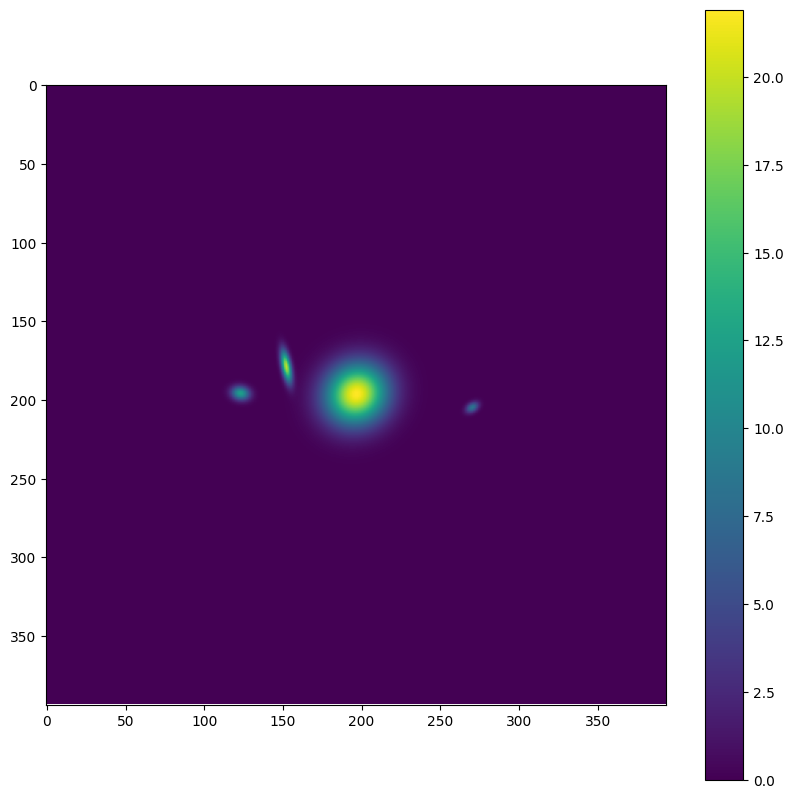

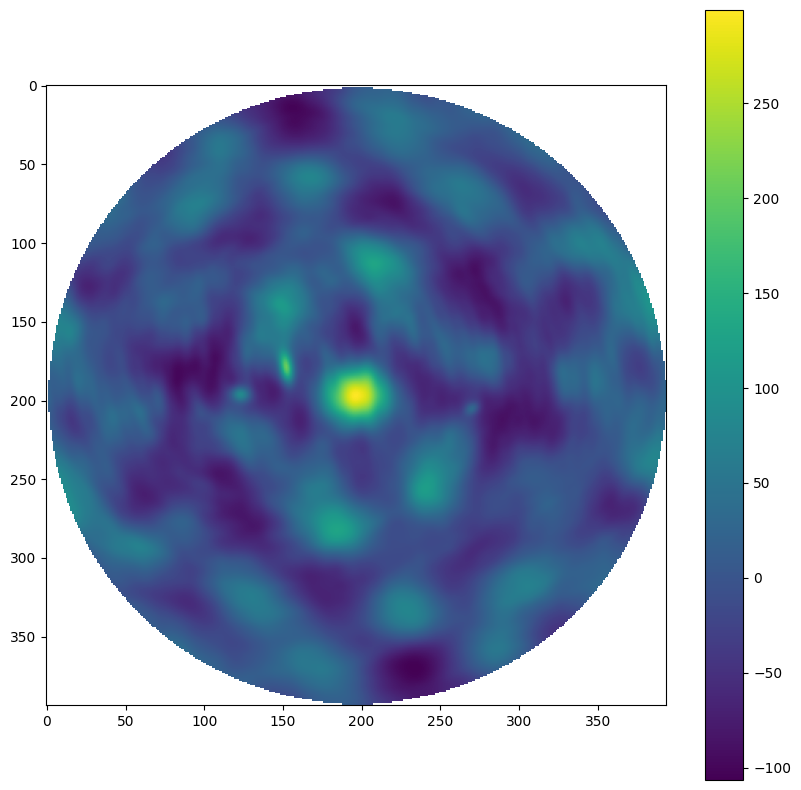

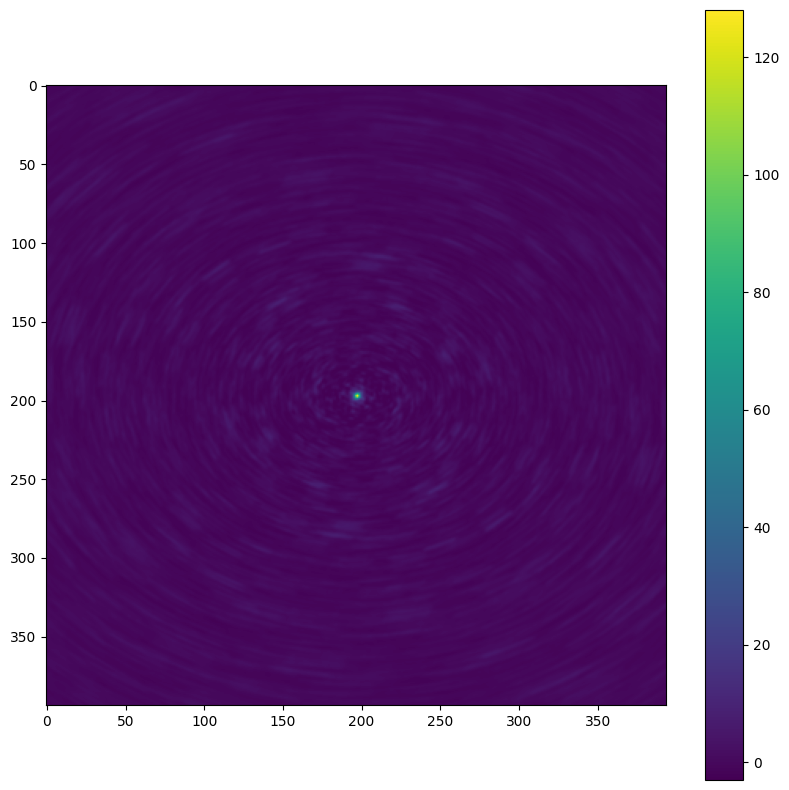

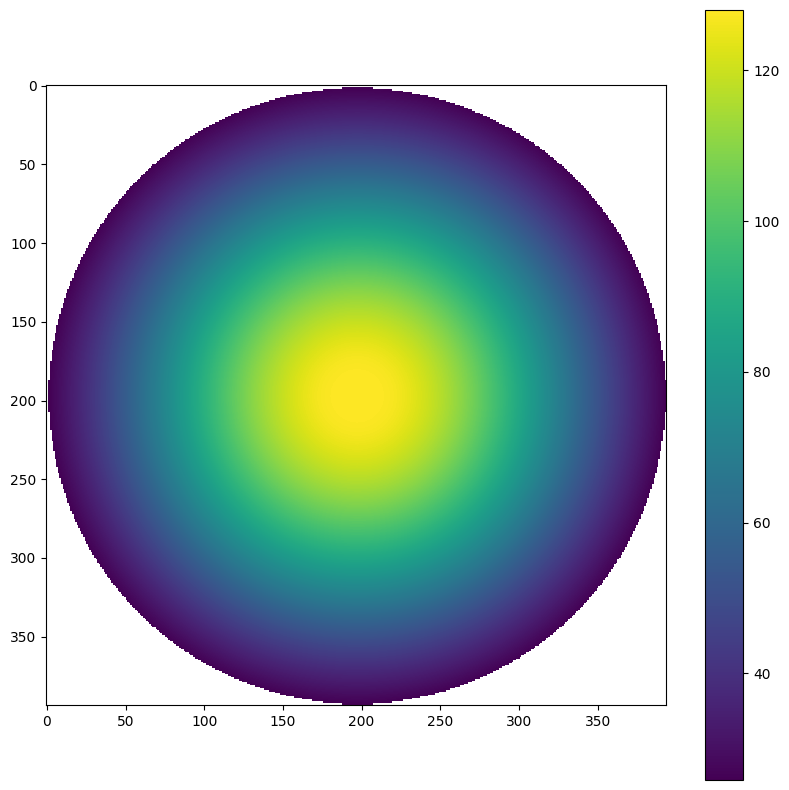

In [4]:
data_dir = '/home/michele/Documents/test-sims'
clean, _ = load_fits(os.path.join(data_dir, 'clean_cube_0.fits'))
dirty, _ = load_fits(os.path.join(data_dir, 'dirty_cube_0.fits'))
#print(extended.shape, gaussian.shape)
psf, _ = load_fits(os.path.join(data_dir, 'psf_0.fits'))
pb, _ = load_fits(os.path.join(data_dir, 'pb_0.fits'))
print(clean.shape, dirty.shape, psf.shape, pb.shape)
plt.figure(figsize=(10,10))
plt.imshow(np.sum(clean[0,:,:], axis=0))
plt.colorbar()
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(np.sum(dirty[0,:,:], axis=0))
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(np.sum(psf[0,:,:], axis=0))
plt.colorbar()
plt.figure(figsize=(10,10))
plt.imshow(np.sum(pb[0,:,:], axis=0))
plt.colorbar()


In [149]:
def _gen_particle_coords(source, datacube):
    # pixels indexed from 0 (not like in FITS!) for better use with numpy
    origin = 0
    skycoords = source.sky_coordinates
    return (
        np.vstack(
            datacube.wcs.sub(3).wcs_world2pix(
                skycoords.ra.to(datacube.units[0]),
                skycoords.dec.to(datacube.units[1]),
                skycoords.radial_velocity.to(datacube.units[2]),
                origin,
            )
        )
        * U.pix
    )

def get_sizes(source, n_px, n_channels):
    
    px_size = 10.0 * U.arcsec
    channel_width=16.0 * U.km * U.s**-1
    datacube = DataCube(
        n_px_x = n_px,
        n_px_y = n_px,
        n_channels = n_channels, 
        px_size = px_size,
        channel_width=channel_width,
        velocity_centre=source.vsys, 
        ra = source.ra,
        dec = source.dec,
    )
    coordinates = _gen_particle_coords(source, datacube)
    min_x, max_x = np.min(coordinates[0,:]), np.max(coordinates[0,:])
    min_y, max_y = np.min(coordinates[1,:]), np.max(coordinates[1,:])
    min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
    while (min_x < 0 * U.pix) or (max_x > n_px * U.pix) or (min_y < 0 * U.pix) or (max_y > n_px * U.pix):
        px_size += 1.0 * U.arcsec
        datacube = DataCube(
            n_px_x = n_px,
            n_px_y = n_px,
            n_channels = n_channels, 
            px_size = px_size,
            channel_width=channel_width,
            velocity_centre=source.vsys, 
            ra = source.ra,
            dec = source.dec,
        )
        coordinates = _gen_particle_coords(source, datacube)
        min_x, max_x = np.min(coordinates[0,:]), np.max(coordinates[0,:])
        min_y, max_y = np.min(coordinates[1,:]), np.max(coordinates[1,:])
        min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
        
    while (min_z < 0 * U.pix) or (max_z > n_channels * U.pix):
        channel_width += 1.0 * U.km * U.s**-1
        datacube = DataCube(
            n_px_x = n_px,
            n_px_y = n_px,
            n_channels = n_channels, 
            px_size = px_size,
            channel_width=channel_width,
            velocity_centre=source.vsys, 
            ra = source.ra,
            dec = source.dec,
        )
        coordinates = _gen_particle_coords(source, datacube)
        min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
    
    coordinates = _gen_particle_coords(source, datacube)
    min_x, max_x = np.min(coordinates[0,:]), np.max(coordinates[0,:])
    min_y, max_y = np.min(coordinates[1,:]), np.max(coordinates[1,:])
    min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
    assert (min_x >= 0* U.pix) and (max_x <= n_pxs* U.pix) and (min_y >= 0* U.pix) and (max_y <= n_pxs* U.pix ), "Source cannot be fitted to cube dimensions"
    return px_size, channel_width 


def get_distance(n_px, n_channels, 
                 x_rot, y_rot, simulation_str, TNGSnapshotID, TNGSubhaloID, 
                 api_key, data_dir, factor):
    distance = 1 * U.Mpc
    source = TNGSource(simulation_str, TNGSnapshotID, TNGSubhaloID,
                       distance=distance,
                       rotation = {'L_coords': (x_rot, y_rot)},
                       cutout_dir = data_dir,
                       api_key = api_key,
                       ra = 0. * U.deg,
                       dec = 0. * U.deg,
                       )
    datacube = DataCube(
        n_px_x = n_px,
        n_px_y = n_px,
        n_channels = n_channels, 
        px_size = 10.0 * U.arcsec,
        channel_width=10.0 * U.km * U.s**-1,
        velocity_centre=source.vsys, 
        ra = source.ra,
        dec = source.dec,
    )
    coordinates = _gen_particle_coords(source, datacube)
    min_x, max_x = np.min(coordinates[0,:]), np.max(coordinates[0,:])
    min_y, max_y = np.min(coordinates[1,:]), np.max(coordinates[1,:])
    min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
    dist_x = max_x - min_x
    dist_y = max_y - min_y
    dist_z = max_z - min_z
    while (dist_x > factor * n_px* U.pix) or (dist_y > factor * n_px* U.pix):
        distance += 10 * U.Mpc
        source = TNGSource(simulation_str, TNGSnapshotID, TNGSubhaloID,
                       distance=distance,
                       rotation = {'L_coords': (x_rot, y_rot)},
                       cutout_dir = data_dir,
                       api_key = api_key,
                       ra = 0. * U.deg,
                       dec = 0. * U.deg,)
    
        datacube = DataCube(
            n_px_x = n_px,
            n_px_y = n_px,
            n_channels = n_channels, 
            px_size = 10.0 * U.arcsec,
            channel_width=10.0 * U.km * U.s**-1,
            velocity_centre=source.vsys, 
            ra = source.ra,
            dec = source.dec,
        )
        coordinates = _gen_particle_coords(source, datacube)
        min_x, max_x = np.min(coordinates[0,:]), np.max(coordinates[0,:])
        min_y, max_y = np.min(coordinates[1,:]), np.max(coordinates[1,:])
        dist_x = max_x - min_x
        dist_y = max_y - min_y
    source = TNGSource(simulation_str, TNGSnapshotID, TNGSubhaloID,
                       distance=distance,
                       rotation = {'L_coords': (x_rot, y_rot)},
                       cutout_dir = data_dir,
                       api_key = api_key,
                       ra = 0. * U.deg,
                       dec = 0. * U.deg,)
    channel_width=10.0 * U.km * U.s**-1
    while dist_z > factor * n_channels * U.pix:
        channel_width += 1.0 * U.km * U.s**-1
        datacube = DataCube(
            n_px_x = n_px,
            n_px_y = n_px,
            n_channels = n_channels, 
            px_size = 10.0 * U.arcsec,
            channel_width=channel_width,
            velocity_centre=source.vsys, 
            ra = source.ra,
            dec = source.dec,
        )
        coordinates = _gen_particle_coords(source, datacube)
        min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
        dist_z = max_z - min_z
        
    return distance, channel_width

In [150]:
id = 0
data_dir = '/media/storage'
main_path = '/home/deepfocus/ALMASim'
plot_dir = 'extended_plots'
output_dir = 'extended_sims_test_0'
project_name = 'sim'
band = 6
antenna_name = 'alma.cycle9.3.3'
inbright = 0.01
bandwidth = 1280
inwidth = 10
integration = 10
totaltime = 4500
pwv = 0.3
snr = 30
get_skymodel = False
extended = True
TNGBasePath = '/media/storage/TNG100-1'
TNGSnapshotID = 99
TNGSubhaloID = 487363
api_key = "8f578b92e700fae3266931f4d785f82c"
plot = True
save_ms = False
crop = False
n_pxs = None
n_channels = None



spatial_resolution = sim.get_spatial_resolution(band, antenna_name) 
central_freq= sim.get_band_central_freq(band)
fov = sim.get_fov([band])[0]
pixel_size = spatial_resolution / 7
n_px = int(1.5 * fov / pixel_size)
if n_channels is None:
    n_channels = int(bandwidth / inwidth)

In [151]:


x_rot = np.random.randint(0, 360) * U.deg
y_rot = np.random.randint(0, 360) * U.deg
simulation_str = TNGBasePath.split('/')[-1]
frequency_resolution  = inwidth * U.MHz
spatial_resolution = spatial_resolution * U.arcsec

central_frequency = central_freq * U.GHz
#px_size, channel_width = get_sizes(source, n_pxs, n_channels)
#print(px_size, channel_width)
hI_rest_frequency = 1420.4 * U.MHz
radio_hI_equivalence = U.doppler_radio(hI_rest_frequency)
velocity_resolution = frequency_resolution.to(U.km / U.s, equivalencies=radio_hI_equivalence)

distance, channel_width = get_distance(n_px, n_channels, x_rot, y_rot,
                         simulation_str, TNGSnapshotID, TNGSubhaloID, api_key, output_dir, factor=4)
print(distance, channel_width)


No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
11.0 Mpc 10.0 km / s


In [175]:
import illustris_python as il
from illustris_python.snapshot import loadSubset, getSnapOffsets
from Hdecompose.atomic_frac import atomic_frac
import astropy.constants as C
from martini.sph_kernels import find_fwhm
from martini.sources.sph_source import SPHSource
import h5py

def partTypeNum(partType):
    """
    Mapping between common names and numeric particle types.

    Reproduced from the illustris_python toolkit.
    """
    if str(partType).isdigit():
        return int(partType)

    if str(partType).lower() in ["gas", "cells"]:
        return 0
    if str(partType).lower() in ["dm", "darkmatter"]:
        return 1
    if str(partType).lower() in ["tracer", "tracers", "tracermc", "trmc"]:
        return 3
    if str(partType).lower() in ["star", "stars", "stellar"]:
        return 4  # only those with GFM_StellarFormationTime>0
    if str(partType).lower() in ["wind"]:
        return 4  # only those with GFM_StellarFormationTime<0
    if str(partType).lower() in ["bh", "bhs", "blackhole", "blackholes"]:
        return 5

    raise Exception("Unknown particle type name.")


def getNumPart(header):
    """
    Calculate number of particles of all types given a snapshot header.

    Reproduced from the illustris_python toolkit.
    """
    nTypes = 6

    nPart = np.zeros(nTypes, dtype=np.int64)
    for j in range(nTypes):
        nPart[j] = header["NumPart_Total"][j] | (
            header["NumPart_Total_HighWord"][j] << 32
        )

    return nPart


def gcPath(basePath, snapNum, chunkNum=0):
    """
    Return absolute path to a group catalog HDF5 file (modify as needed).

    Reproduced from the illustris_python toolkit.
    """
    gcPath = basePath + "/groups_%03d/" % snapNum
    filePath1 = gcPath + "groups_%03d.%d.hdf5" % (snapNum, chunkNum)
    filePath2 = gcPath + "fof_subhalo_tab_%03d.%d.hdf5" % (snapNum, chunkNum)

    if os.path.isfile(filePath1):
        return filePath1
    return filePath2


def offsetPath(basePath, snapNum):
    """
    Return absolute path to a separate offset file (modify as needed).

    Reproduced from the illustris_python toolkit.
    """
    offsetPath = basePath + "/../postprocessing/offsets/offsets_%03d.hdf5" % snapNum

    return offsetPath


def snapPath(basePath, snapNum, chunkNum=0):
    """Return absolute path to a snapshot HDF5 file (modify as needed)."""
    snapPath = basePath + "/snapdir_" + str(snapNum).zfill(3) + "/"
    filePath = snapPath + "snap_" + str(snapNum).zfill(3)
    filePath += "." + str(chunkNum) + ".hdf5"
    return filePath


def loadSingle(basePath, snapNum, haloID=-1, subhaloID=-1):
    """
    Return complete group catalog information for one halo or subhalo.

    Reproduced from the illustris_python toolkit.
    """
    import h5py

    if (haloID < 0 and subhaloID < 0) or (haloID >= 0 and subhaloID >= 0):
        raise Exception("Must specify either haloID or subhaloID (and not both).")

    gName = "Subhalo" if subhaloID >= 0 else "Group"
    searchID = subhaloID if subhaloID >= 0 else haloID

    # old or new format
    if "fof_subhalo" in gcPath(basePath, snapNum):
        # use separate 'offsets_nnn.hdf5' files
        with h5py.File(offsetPath(basePath, snapNum), "r") as f:
            offsets = f["FileOffsets/" + gName][()]
    else:
        # use header of group catalog
        with h5py.File(gcPath(basePath, snapNum), "r") as f:
            offsets = f["Header"].attrs["FileOffsets_" + gName]

    offsets = searchID - offsets
    fileNum = np.max(np.where(offsets >= 0))
    groupOffset = offsets[fileNum]

    # load halo/subhalo fields into a dict
    result = {}

    with h5py.File(gcPath(basePath, snapNum, fileNum), "r") as f:
        for haloProp in f[gName].keys():
            result[haloProp] = f[gName][haloProp][groupOffset]

    return result


def loadSubset(
    basePath,
    snapNum,
    partType,
    fields=None,
    subset=None,
    mdi=None,
    sq=True,
    float32=False,
):
    """
    Load a subset of fields for all particles/cells of a given partType.
    If offset and length specified, load only that subset of the partType.
    If mdi is specified, must be a list of integers of the same length as fields,
    giving for each field the multi-dimensional index (on the second dimension) to load.
      For example, fields=['Coordinates', 'Masses'] and mdi=[1, None] returns a 1D array
      of y-Coordinates only, together with Masses.
    If sq is True, return a numpy array instead of a dict if len(fields)==1.
    If float32 is True, load any float64 datatype arrays directly as float32
    (save memory).

    Reproduced from the illustris_python toolkit.
    """
    import h5py
    import six

    result = {}

    ptNum = partTypeNum(partType)
    gName = "PartType" + str(ptNum)

    # make sure fields is not a single element
    if isinstance(fields, six.string_types):
        fields = [fields]

    # load header from first chunk
    with h5py.File(snapPath(basePath, snapNum), "r") as f:
        header = dict(f["Header"].attrs.items())
        nPart = getNumPart(header)

        # decide global read size, starting file chunk, and starting file chunk offset
        if subset:
            offsetsThisType = (
                subset["offsetType"][ptNum] - subset["snapOffsets"][ptNum, :]
            )

            fileNum = np.max(np.where(offsetsThisType >= 0))
            fileOff = offsetsThisType[fileNum]
            numToRead = subset["lenType"][ptNum]
        else:
            fileNum = 0
            fileOff = 0
            numToRead = nPart[ptNum]

        result["count"] = numToRead

        if not numToRead:
            # print('warning: no particles of requested type, empty return.')
            return result

        # find a chunk with this particle type
        i = 1
        while gName not in f:
            f = h5py.File(snapPath(basePath, snapNum, i), "r")
            i += 1

        # if fields not specified, load everything
        if not fields:
            fields = list(f[gName].keys())

        for i, field in enumerate(fields):
            # verify existence
            if field not in f[gName].keys():
                raise Exception(
                    "Particle type ["
                    + str(ptNum)
                    + "] does not have field ["
                    + field
                    + "]"
                )

            # replace local length with global
            shape = list(f[gName][field].shape)
            shape[0] = numToRead

            # multi-dimensional index slice load
            if mdi is not None and mdi[i] is not None:
                if len(shape) != 2:
                    raise Exception(
                        "Read error: mdi requested on non-2D field [" + field + "]"
                    )
                shape = [shape[0]]

            # allocate within return dict
            dtype = f[gName][field].dtype
            if dtype == np.float64 and float32:
                dtype = np.float32
            result[field] = np.zeros(shape, dtype=dtype)

    # loop over chunks
    wOffset = 0
    origNumToRead = numToRead

    while numToRead:
        f = h5py.File(snapPath(basePath, snapNum, fileNum), "r")

        # no particles of requested type in this file chunk?
        if gName not in f:
            f.close()
            fileNum += 1
            fileOff = 0
            continue

        # set local read length for this file chunk, truncate to be within the local size
        numTypeLocal = f["Header"].attrs["NumPart_ThisFile"][ptNum]

        numToReadLocal = numToRead

        if fileOff + numToReadLocal > numTypeLocal:
            numToReadLocal = numTypeLocal - fileOff

        # loop over each requested field for this particle type
        for i, field in enumerate(fields):
            # read data local to the current file
            if mdi is None or mdi[i] is None:
                result[field][wOffset : wOffset + numToReadLocal] = f[gName][field][
                    fileOff : fileOff + numToReadLocal
                ]
            else:
                result[field][wOffset : wOffset + numToReadLocal] = f[gName][field][
                    fileOff : fileOff + numToReadLocal, mdi[i]
                ]

        wOffset += numToReadLocal
        numToRead -= numToReadLocal
        fileNum += 1
        fileOff = 0  # start at beginning of all file chunks other than the first

        f.close()

    # verify we read the correct number
    if origNumToRead != wOffset:
        raise Exception(
            "Read ["
            + str(wOffset)
            + "] particles, but was expecting ["
            + str(origNumToRead)
            + "]"
        )

    # only a single field? then return the array instead of a single item dict
    if sq and len(fields) == 1:
        return result[fields[0]]

    return result


def loadHeader(basePath, snapNum):
    """
    Load the group catalog header.

    Reproduced from the illustris_python toolkit.
    """
    import h5py

    with h5py.File(gcPath(basePath, snapNum), "r") as f:
        header = dict(f["Header"].attrs.items())

    return header

class myTNGSource(SPHSource):
    def __init__(
        self,
        snapNum,
        subID,
        basePath=None,
        distance=3.0 * U.Mpc,
        vpeculiar=0 * U.km / U.s,
        rotation={"rotmat": np.eye(3)},
        ra=0.0 * U.deg,
        dec=0.0 * U.deg,
    ):
        X_H = 0.76

        full_fields_g = (
            "Masses",
            "Velocities",
            "InternalEnergy",
            "ElectronAbundance",
            "Density",
            "CenterOfMass",
            "GFM_Metals",
        )
        mdi_full = [None, None, None, None, None, None, 0]
        mini_fields_g = (
            "Masses",
            "Velocities",
            "InternalEnergy",
            "ElectronAbundance",
            "Density",
            "Coordinates",
        )
        data_header = loadHeader(basePath, snapNum)
        data_sub = loadSingle(basePath, snapNum, subhaloID=subID)
        haloID = data_sub["SubhaloGrNr"]
        subset_g = getSnapOffsets(basePath, snapNum, haloID, "Group")
        try:
            data_g = loadSubset(
                    basePath,
                    snapNum,
                    "gas",
                    fields=full_fields_g,
                    subset=subset_g,
                    mdi=mdi_full,
                )
            minisnap = False
        except Exception as exc:
            if ("Particle type" in exc.args[0]) and ("does not have field" in exc.args[0]):
                data_g.update(
                        loadSubset(
                            basePath,
                            snapNum,
                            "gas",
                            fields=("CenterOfMass",),
                            subset=subset_g,
                            sq=False,
                        )
                    )
                minisnap = True
                X_H_g = X_H
            else:
                raise
        X_H_g = (
                X_H if minisnap else data_g["GFM_Metals"])  # only loaded column 0: Hydrogen
        a = data_header["Time"]
        z = data_header["Redshift"]
        h = data_header["HubbleParam"]
        xe_g = data_g["ElectronAbundance"]
        rho_g = data_g["Density"] * 1e10 / h * U.Msun * np.power(a / h * U.kpc, -3)
        u_g = data_g["InternalEnergy"]  # unit conversion handled in T_g
        mu_g = 4 * C.m_p.to(U.g).value / (1 + 3 * X_H_g + 4 * X_H_g * xe_g)
        gamma = 5.0 / 3.0  # see http://www.tng-project.org/data/docs/faq/#gen4
        T_g = (gamma - 1) * u_g / C.k_B.to(U.erg / U.K).value * 1e10 * mu_g * U.K
        m_g = data_g["Masses"] * 1e10 / h * U.Msun
        # cast to float64 to avoid underflow error
        nH_g = U.Quantity(rho_g * X_H_g / mu_g, dtype=np.float64) / C.m_p
        # In TNG_corrections I set f_neutral = 1 for particles with density
        # > .1cm^-3. Might be possible to do a bit better here, but HI & H2
        # tables for TNG will be available soon anyway.
        fatomic_g = atomic_frac(
            z, nH_g, T_g, rho_g, X_H_g, onlyA1=True, TNG_corrections=True
            )
        mHI_g = m_g * X_H_g * fatomic_g
        try:
            xyz_g = data_g["CenterOfMass"] * a / h * U.kpc
        except KeyError:
            xyz_g = data_g["Coordinates"] * a / h * U.kpc
        vxyz_g = data_g["Velocities"] * np.sqrt(a) * U.km / U.s
        V_cell = (
            data_g["Masses"] / data_g["Density"] * np.power(a / h * U.kpc, 3)
            )  # Voronoi cell volume
        r_cell = np.power(3.0 * V_cell / 4.0 / np.pi, 1.0 / 3.0).to(U.kpc)
        # hsm_g has in mind a cubic spline that =0 at r=h, I think
        hsm_g = 2.5 * r_cell * find_fwhm(CubicSplineKernel().kernel)
        xyz_centre = data_sub["SubhaloPos"] * a / h * U.kpc
        xyz_g -= xyz_centre
        vxyz_centre = data_sub["SubhaloVel"] * np.sqrt(a) * U.km / U.s
        vxyz_g -= vxyz_centre
        super().__init__(
            distance=distance,
            vpeculiar=vpeculiar,
            rotation=rotation,
            ra=ra,
            dec=dec,
            h=h,
            T_g=T_g,
            mHI_g=mHI_g,
            xyz_g=xyz_g,
            vxyz_g=vxyz_g,
            hsm_g=hsm_g,
        )
        return

In [176]:


basePath = '/media/storage/TNG100-1/output'
snapNum = 99
subID = 0
source = myTNGSource(TNGSnapshotID, TNGSubhaloID,
                       distance=distance,
                       basePath = basePath,
                       rotation = {'L_coords': (x_rot, y_rot)},
                       ra = 0. * U.deg,
                       dec = 0. * U.deg,)

No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5


In [132]:
source = TNGSource(simulation_str, TNGSnapshotID, TNGSubhaloID,
                       distance=distance,
                       rotation = {'L_coords': (x_rot, y_rot)},
                       cutout_dir = None,
                       api_key = api_key,
                       ra = 0. * U.deg,
                       dec = 0. * U.deg,)


datacube = DataCube(
        n_px_x = n_px,
        n_px_y = n_px,
        n_channels = n_channels, 
        px_size = 10.0 * U.arcsec,
        channel_width=channel_width,
        velocity_centre=source.vsys, 
        ra = source.ra,
        dec = source.dec,
    )

spectral_model = GaussianSpectrum(
        sigma="thermal"
    )
sph_kernel = AdaptiveKernel(
    (
        CubicSplineKernel(),
        GaussianKernel(truncate=6)
    ), verbose=False
    )

M = Martini(
        source=source,
        datacube=datacube,
        sph_kernel=sph_kernel,
        spectral_model=spectral_model)
    
M.insert_source_in_cube(skip_validation=True)

No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
Source module contained 89450 particles with total HI mass of 1.03e+11 solMass.
Pruned particles that will not contribute to data cube, 89450 particles remaining with total HI mass of 1.03e+11 solMass.
    ---------AdaptiveKernel VALIDATION---------
    Median smoothing length:  1.5752039455745848 pix px
    Minimum smoothing length:  0.21278003465386533 pix px
    Maximum smoothing length:  18.84124258125299 pix px
    Smoothing length histogram (np.histogram): (array([50813, 11049,  7546,  9899,  7823,  1844,   361,    86,    24,
           5]), <Quantity [ 0.21278003,  2.07562629,  3.93847254,  5.8013188 ,  7.66416505,
            9.52701131, 11.38985756, 13.25270382, 15.11555007, 16.97839633,
           18.84124258] pix>)
     1260 / 89450 smoothing lengths fail validation.
    -------------------------------------------
Inserting source in cube.


100%|██████████| 155236/155236 [02:24<00:00, 1074.30it/s]


Source inserted.
  Flux in cube: 9.55e+00 Jy
  Mass in cube (assuming distance 41.00 Mpc): 1.02e+11 solMass
    [99% of initial source mass]
  Maximum pixel: 6.07e-05 Jy / arcsec2
  Median non-zero pixel: 1.67e-13 Jy / arcsec2


Skymodel saved to /media/storage/skymodel_0.fits
(394, 394, 128, 1)


FileNotFoundError: [Errno 2] No such file or directory: 'extended_plots/skymodel_0.png'

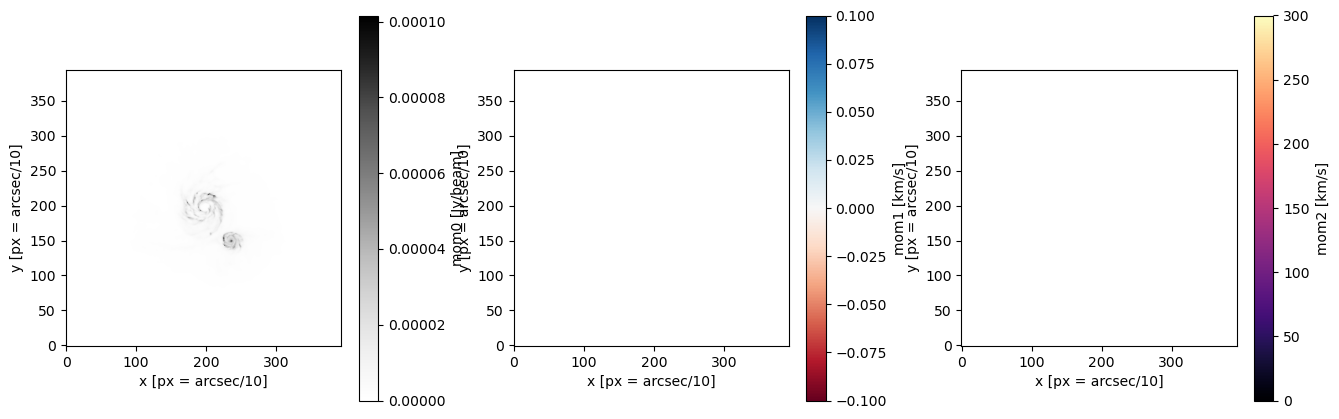

In [133]:
M.write_hdf5(os.path.join(data_dir, 'skymodel_{}.hdf5'.format(str(id))), channels='velocity')
f = h5py.File(os.path.join(data_dir, 'skymodel_{}.hdf5'.format(str(id))),'r')
vch = f['channel_mids'][()] / 1E3 - source.distance.to(U.Mpc).value*70  # m/s to km/s
f.close()
os.remove(os.path.join(data_dir, 'skymodel_{}.hdf5'.format(str(id))))
filename = os.path.join(data_dir, 'skymodel_{}.fits'.format(id))
#M.write_fits(filename, channels='velocity')
write_datacube_to_fits(M.datacube, filename)
print('Skymodel saved to {}'.format(filename))
if plot is True:
    SkyCube = M.datacube._array.value
print(SkyCube.shape)
plot_moments(SkyCube[:, :, :, 0], vch, os.path.join(plot_dir, 'skymodel_{}.png'.format(str(id))))